In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [226]:
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [227]:
from pandas_datareader import data

In [228]:
tickers = ['AAPL', 'SPY', 'IVW', 'IYW', 'IJS', 'VB']
data_source = 'google'
start_date = '2010-01-01'
end_date = '2016-12-31'

In [229]:
panel_data = data.DataReader(tickers, data_source, start_date, end_date)
close = panel_data.loc['Close'].pct_change().dropna()

In [230]:
X = close.columns[1:]
y = close.columns[0]

In [231]:
def best_features(importances, threshold=0.1):
    temp = importances.argsort()
    ranks = np.empty(len(importances), int)
    ranks[temp] = np.arange(len(importances))
    opt_features = []
    for x in range(len(importances)-1, -1, -1):
        idx = np.where(ranks == x)[0][0]
        if importances[idx] < threshold:
            return opt_features
        else:
            opt_features.append(X[idx])
    return opt_features

In [233]:
def train_and_test(X, y, df, estimator, param_grid, cv, threshold = 0.1, test_size = 0.25):
    
    # Split data set in to training and test, sets random seed for testing, remove when live
    X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size = test_size, random_state = 0)
    
    # Use Decision Tree to identify best features
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    importances = rfr.feature_importances_
    opt_features = best_features(importances, threshold=threshold)
    
    # Perform GridSearch to get optimal parameters
    clf = GridSearchCV(estimator, param_grid, cv=cv, n_jobs = -1, verbose = 1)
    clf.fit(X_train[opt_features], y_train)
    opt_model = clf.best_estimator_
    
    # Refit optimal model on optimal features and obtain model metric
    opt_model.fit(X_train[opt_features], y_train)
    predictions = opt_model.predict(X_test[opt_features])
    r2 = r2_score(y_test, predictions)
    
    res = [[opt_model, opt_features, r2]]
    
    #return res
    return pd.DataFrame(res, columns=['Optimal Model', 'Optimal Features', 'R^2'], index=['Results']).T

In [234]:
cv = KFold(10, random_state=0)
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
X = close.columns[1:]
y = close.columns[0]
estimator = LinearRegression()

In [235]:
res = train_and_test(X, y, close, estimator, param_grid, cv)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.5s finished


In [236]:
opt_model, opt_feat = res.loc['Optimal Model'][0], res.loc['Optimal Features'][0]
opt_feat

['IYW', 'IVW', 'SPY']

In [237]:
predictions = opt_model.predict(close[opt_feat])
r_2 = r2_score(close[y], predictions)
pred_ts = (1+predictions).cumprod()
actual_ts = (1+close[y]).cumprod()

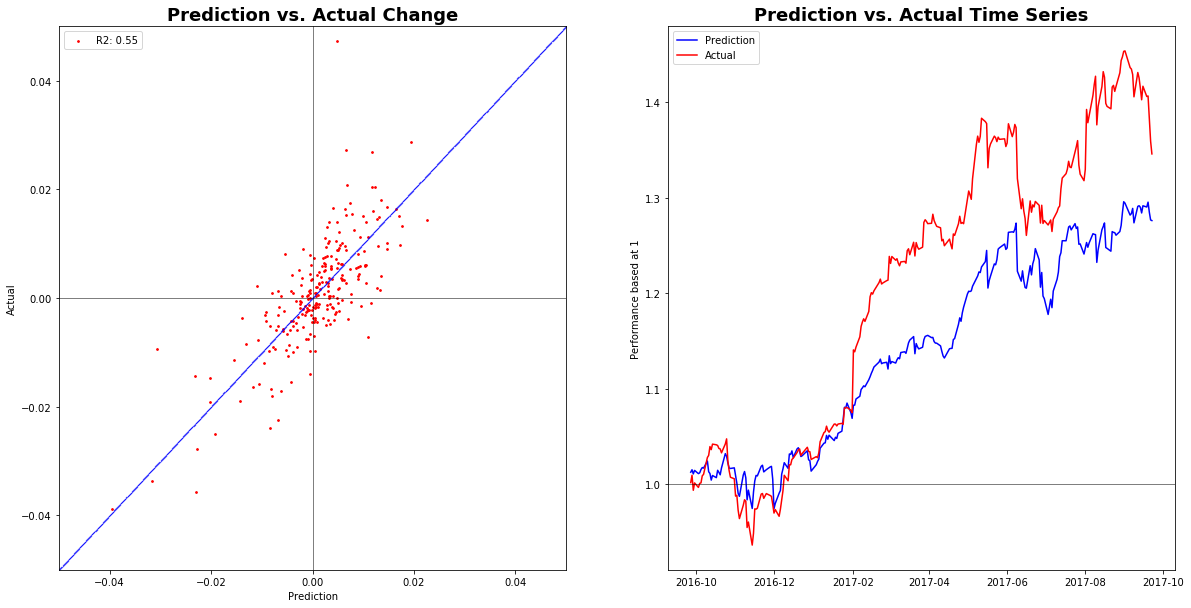

In [238]:
plt.figure(figsize=[20, 10])
ax1 = plt.subplot(1, 2, 1)

ax1.scatter(predictions, close[y], s=3, c='r', label='R2: '+str(round(r_2,2)))
ax1.scatter(np.linspace(-0.05, 0.05, 1000), np.linspace(-0.05, 0.05, 1000), s=0.1, c='b')
ax1.set_xlim(-0.05, 0.05)
ax1.set_ylim(-0.05, 0.05)
ax1.axhline(y=0.0, color='black', linestyle='-', linewidth=0.5)
ax1.axvline(x=0.0, color='black', linestyle='-', linewidth=0.5)
ax1.set_title('Prediction vs. Actual Change', fontsize=18, fontweight='bold')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('Actual')
ax1.legend(loc='best')

ax2 = plt.subplot(1, 2, 2)
ax2.plot(close.index, pred_ts, label='Prediction', c='b')
ax2.plot(close.index, actual_ts, label='Actual', c='r')
ax2.axhline(y=1.0, color='black', linestyle='-', linewidth=0.5)
ax2.set_title('Prediction vs. Actual Time Series', fontsize=18, fontweight='bold')
ax2.set_ylabel('Performance based at 1')
ax2.legend(loc='best')
plt.show()